# Question answering

In [2]:
#@title
from IPython.display import HTML

#HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/ajPx5LwJD-I?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

Question answering tasks return an answer given a question. If you've ever asked a virtual assistant like Alexa, Siri or Google what the weather is, then you've used a question answering model before. There are two common types of question answering tasks:

- Extractive: extract the answer from the given context.
- Abstractive: generate an answer from the context that correctly answers the question.

We encourage you to login to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to login:

In [49]:
from huggingface_hub import notebook_login

notebook_login()

## Define globals

In [6]:
DISTILBERT = "distilbert-base-uncased"
T5_SMALL = "t5-small"
GPT2 = "GPT2"

## Load SQuAD dataset

Start by loading a smaller subset of the SQuAD dataset from the 🤗 Datasets library. This'll give you a chance to experiment and make sure everything works before spending more time training on the full dataset.

In [3]:
from datasets import load_dataset

raw_datasets = load_dataset("squad")#, split="train")

Found cached dataset squad (/home/jovyan/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

Split the dataset's `train` split into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [4]:
#raw_datasets = squad.train_test_split(test_size=0.2)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

Then take a look at an example:

In [5]:
raw_datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

There are several important fields here:

- `answers`: the starting location of the answer token and the answer text.
- `context`: background information from which the model needs to extract the answer.
- `question`: the question a model should answer.

## Preprocess

The next step is to load a DistilBERT tokenizer to process the `question` and `context` fields:

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(T5_SMALL)

#### play around

In [8]:
tokenizer.is_fast
sample = raw_datasets['train'][0]
print(sample['context'])
encodings = tokenizer(sample['context'])
tokenizer.decode(encodings['input_ids'])
print('tokens:\t', encodings.tokens())
print('word_ids that tokens correspond to:\t', encodings.word_ids())

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
tokens:	 ['▁Architectural', 'ly', ',', '▁the', '▁school', '▁has', '▁', 'a', '▁Catholic', '▁character', '.', '▁A', 'top', '▁the', '▁Main', '▁Building', "'", 's', '▁gold', '▁dome', '▁is', '▁', 'a', '▁golden', '▁statue', '▁of', '▁the', '▁Virgin', '▁Mary', '.', '▁', 'Immediately', '▁in', '▁front', '▁of', '▁

In [9]:
inputs = tokenizer(
    sample['question'],
    sample['context'],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))


To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?</s> Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart</s>
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?</s> Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the </s>
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?</s>nite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica 

**overflow_to_sample_mapping**

As we can see, we get back the usual input IDs, token type IDs, and attention mask, as well as the offset mapping we required and an extra key, `overflow_to_sample_mapping`. The corresponding value will be of use to us when we tokenize several texts at the same time (which we should do to benefit from the fact that our tokenizer is backed by Rust). Since one sample can give several features, it maps each feature to the example it originated from. Because here we only tokenized one example, we get a list of 0s:

In [10]:
inputs["overflow_to_sample_mapping"]


[0, 0, 0, 0, 0]

 But if we tokenize more examples, this will become more useful (Seen below):
 
 As we can see, the first three examples (at indices 2, 3, and 4 in the training set) each gave four features and the last example (at index 5 in the training set) gave 7 features.

This information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

(0, 0) if the answer is not in the corresponding span of the context
(start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends

In [11]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 21 features.
Here is where each comes from: [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3].


In [12]:
inputs['overflow_to_sample_mapping']

[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]

#### back to business

There are a few preprocessing steps particular to question answering tasks you should be aware of:

1. Some examples in a dataset may have a very long `context` that exceeds the maximum input length of the model. To deal with longer sequences, truncate only the `context` by setting `truncation="only_second"`.
2. Next, map the start and end positions of the answer to the original `context` by setting
   `return_offset_mapping=True`.
3. With the mapping in hand, now you can find the start and end tokens of the answer. Use the [sequence_ids](https://huggingface.co/docs/tokenizers/main/en/api/encoding#tokenizers.Encoding.sequence_ids) method to
   find which part of the offset corresponds to the `question` and which corresponds to the `context`.

Here is how you can create a function to truncate and map the start and end tokens of the `answer` to the `context`:

Note, the answer offsets are provided as character offsets. We transform those to token level offsets using the `preprocess_function` below

In [24]:
raw_datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

(array([1.1575e+04, 5.1126e+04, 1.8067e+04, 5.0720e+03, 1.3190e+03,
        3.1600e+02, 7.2000e+01, 3.3000e+01, 4.0000e+00, 1.5000e+01]),
 array([ 151. ,  506.5,  862. , 1217.5, 1573. , 1928.5, 2284. , 2639.5,
        2995. , 3350.5, 3706. ]),
 <BarContainer object of 10 artists>)

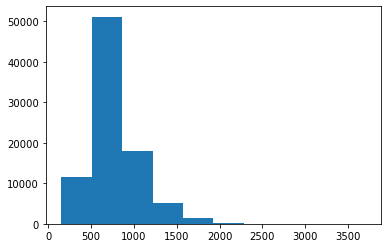

In [23]:
question_lens = []
context_lens = []
for sample in raw_datasets["train"]["context"]:
    context_lens.append(len(sample))

import matplotlib.pyplot as plt    
plt.hist(context_lens)

In [46]:
max_length = 384
stride = 128

max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_input_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []
    answers_text = []
    
    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        answer_text = answer["text"][0]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
            answers_text.append("")
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
            answers_text.append(answer_text)
    labels = tokenizer(
        answers_text, max_length=max_target_length, truncation=True
    )

    #if (start_positions and end_positions):
    inputs["labels"] = labels["input_ids"]

    return inputs

**DOUBT: is it okay to select the answer as first instance in list diring training?**

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once. Remove any columns you don't need:

In [47]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

(87599, 87735)

In [48]:
train_dataset[:9]['labels']

[[101, 2216, 17666, 6397, 3786, 1573, 25422, 13149, 102],
 [101, 170, 7335, 5921, 1104, 4028, 102],
 [101, 1103, 4304, 4334, 102],
 [101, 170, 14789, 1282, 1104, 8070, 1105, 9284, 102],
 [101, 170, 5404, 5921, 1104, 1103, 6567, 2090, 102],
 [101, 1347, 6789, 102],
 [101, 3059, 102],
 [101, 1109, 16460, 102],
 [101, 1210, 102]]

Now create a batch of examples using [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator). Unlike other data collators in 🤗 Transformers, the [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator) does not apply any additional preprocessing such as padding.

In [52]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

### Processing the validation data
Preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings and some way to match each created feature to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the sequence_ids() method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to None:


In [35]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [36]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10896)

### training

In [51]:
from transformers import AutoModelForSeq2SeqLM
model_name = "MaRiOrOsSi/t5-base-finetuned-question-answering"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


### under the hood of compute_metrics

The model will output logits for the start and end positions of the answer in the input IDs, as we saw during our exploration of the question-answering pipeline. The post-processing step will be similar to what we did there, so here’s a quick reminder of the actions we took:

We masked the start and end logits corresponding to tokens outside of the context.
We then converted the start and end logits into probabilities using a softmax.
We attributed a score to each (start_token, end_token) pair by taking the product of the corresponding two probabilities.
We looked for the pair with the maximum score that yielded a valid answer (e.g., a start_token lower than end_token).
Here we will change this process slightly because we don’t need to compute actual scores (just the predicted answer). This means we can skip the softmax step. To go faster, we also won’t score all the possible (start_token, end_token) pairs, but only the ones corresponding to the highest n_best logits (with n_best=20). Since we will skip the softmax, those scores will be logit scores, and will be obtained by taking the sum of the start and end logits (instead of the product, because of the rule 
log
⁡
(
�
�
)
=
log
⁡
(
�
)
+
log
⁡
(
�
)
log(ab)=log(a)+log(b)).

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant tokenizer, we just have to change that object to the tokenizer of the model we want to use temporarily:m

In [39]:
small_eval_set = raw_datasets["validation"].select(range(100))
#trained_checkpoint =  "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-9618a33c483af167.arrow


In [38]:
QA_MODEL = "my_awesome_qa_model_20230617/checkpoint-1000"
trained_checkpoint = QA_MODEL #"distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)

We then remove the columns of our eval_set that are not expected by the model, build a batch with all of that small validation set, and pass it through the model. If a GPU is available, we use it to go faster:



In [112]:
import torch
from transformers import AutoModelForSeq2SeqLM

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

Since the Trainer will give us predictions as NumPy arrays, we grab the start and end logits and convert them to that format:



In [114]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our small_eval_set. One example may have been split into several features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set:



In [115]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

* An answer that wouldn’t be inside the context
* An answer with negative length
* An answer that is too long (we limit the possibilities at max_answer_length=30)

Once we have all the scored possible answers for one example, we just pick the one with the best logit score:


In [116]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

The final format of the predicted answers is the one that will be expected by the metric we will use. As usual, we can load it with the help of the 🤗 Evaluate library:

This metric expects the predicted answers in the format we saw above (a list of dictionaries with one key for the ID of the example and one key for the predicted text) and the theoretical answers in the format below (a list of dictionaries with one key for the ID of the example and one key for the possible answers):



In [117]:
import evaluate

metric = evaluate.load("squad")
#metric

In [120]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

In [121]:
# We can now check that we get sensible results by looking at the first element of both lists:

print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


In [123]:
# Not too bad! Now let’s have a look at the score the metric gives us:

metric.compute(predictions=predicted_answers, references=theoretical_answers)


{'exact_match': 83.0, 'f1': 88.25000000000004}

Again, that’s rather good considering that according to its paper DistilBERT fine-tuned on SQuAD obtains 79.1 and 86.9 for those scores on the whole dataset.

Now let’s put everything we just did in a compute_metrics() function that we will use in the Trainer. Normally, that compute_metrics() function only receives a tuple eval_preds with logits and labels. Here we will need a bit more, as we have to look in the dataset of features for the offset and in the dataset of examples for the original contexts, so we won’t be able to use this function to get regular evaluation results during training. We will only use it at the end of training to check the results.

The compute_metrics() function groups the same steps as before; we just add a small check in case we don’t come up with any valid answers (in which case we predict an empty string).




## Train

In [108]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [124]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 83.0, 'f1': 88.25000000000004}

### fine tuning

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load DistilBERT with [AutoModelForQuestionAnswering](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForQuestionAnswering):

In [15]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased") # pretrained_checkpoint

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Once this is done, we can define our TrainingArguments. As we said when we defined our function to compute the metric, we won’t be able to have a regular evaluation loop because of the signature of the compute_metrics() function. We could write our own subclass of Trainer to do this (an approach you can find in the question answering example script), but that’s a bit too long for this section. Instead, we will only evaluate the model at the end of training here and show you how to do a regular evaluation in “A custom training loop” below.

`This is really where the Trainer API shows its limits and the 🤗 Accelerate library shines: customizing the class to a specific use case can be painful, but tweaking a fully exposed training loop is easy.`



At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model).
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, and data collator.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [19]:
MODEL_DIR = "my_awesome_qa_model_20230617"

from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

We’ve seen most of these before: we set some hyperparameters (like the learning rate, the number of epochs we train for, and some weight decay) and indicate that we want to save the model at the end of every epoch, skip evaluation, and upload our results to the Model Hub. We also enable mixed-precision training with fp16=True, as it can speed up the training nicely on a recent GPU.


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.735640
2,1.016100,1.805603
3,1.016100,1.755508
4,0.585100,1.934661
5,0.585100,1.987095


TrainOutput(global_step=1250, training_loss=0.7263977905273438, metrics={'train_runtime': 273.0865, 'train_samples_per_second': 73.237, 'train_steps_per_second': 4.577, 'total_flos': 1959796500480000.0, 'train_loss': 0.7263977905273438, 'epoch': 5.0})

Note that while the training happens, each time the model is saved (here, every epoch) it is uploaded to the Hub in the background. This way, you will be able to to resume your training on another machine if necessary. The whole training takes a while (a little over an hour on a Titan RTX), so you can grab a coffee or reread some of the parts of the course that you’ve found more challenging while it proceeds. Also note that as soon as the first epoch is finished, you will see some weights uploaded to the Hub and you can start playing with your model on its page.


Once the training is complete, we can finally evaluate our model (and pray we didn’t spend all that compute time on nothing). The predict() method of the Trainer will return a tuple where the first elements will be the predictions of the model (here a pair with the start and end logits). We send this to our compute_metrics() function:




In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [17]:
trainer.push_to_hub()

OSError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.


`https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt#a-custom-training-loop|`

<Tip>
   
For a more in-depth example of how to finetune a model for question answering, take a look at the corresponding
[PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering.ipynb)
or [TensorFlow notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering-tf.ipynb).

</Tip>

### inference

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

## Evaluate

Evaluation for question answering requires a significant amount of postprocessing. To avoid taking up too much of your time, this guide skips the evaluation step. The [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) still calculates the evaluation loss during training so you're not completely in the dark about your model's performance.

If have more time and you're interested in how to evaluate your model for question answering, take a look at the [Question answering](https://huggingface.co/course/chapter7/7?fw=pt#postprocessing) chapter from the 🤗 Hugging Face Course!

CRITICAL! https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt

In [63]:
stride = 50
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [65]:
context = squad["train"][0]["context"]
question = squad["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] how many animals did mu ying capture? [SEP] patricia ebrey writes that tibet, like joseon korea and other neighboring states to the ming, settled for its tributary status while there were no troops or governors of ming china stationed in its territory. laird writes that " after the mongol troops left tibet, no ming troops replaced them. " wang and nyima state that, despite the fact that the ming refrained from sending troops to subdue tibet and refrained from garrisoning ming troops there, these measures were unnecessary so long as the ming court upheld close ties with tibetan vassals and their forces. however, there were instances in the 14th century when the hongwu emperor did use military force to quell unrest in tibet. john d. langlois writes that there was unrest in tibet and western sichuan, which the marquis mu ying ( [UNK] 英 ) was commissioned to quell in november 1378 after he established a taozhou garrison in gansu. langlois notes that by october 1379, mu ying had alle

In [69]:
inputs = tokenizer(
    question,
    context,
    max_length=200,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] how many animals did mu ying capture? [SEP] patricia ebrey writes that tibet, like joseon korea and other neighboring states to the ming, settled for its tributary status while there were no troops or governors of ming china stationed in its territory. laird writes that " after the mongol troops left tibet, no ming troops replaced them. " wang and nyima state that, despite the fact that the ming refrained from sending troops to subdue tibet and refrained from garrisoning ming troops there, these measures were unnecessary so long as the ming court upheld close ties with tibetan vassals and their forces. however, there were instances in the 14th century when the hongwu emperor did use military force to quell unrest in tibet. john d. langlois writes that there was unrest in tibet and western sichuan, which the marquis mu ying ( [UNK] 英 ) was commissioned to quell in november 1378 after he established a taozhou garrison in gansu. langlois notes that by october [SEP]
[CLS] how many an

In [64]:
small_eval_set = squad["test"].select(range(100))
trained_checkpoint = QA_MODEL #"distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=squad["test"].column_names,
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [71]:
tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

In [73]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our small_eval_set. One example may have been split into several features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set:



In [75]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

An answer that wouldn’t be inside the context
An answer with negative length
An answer that is too long (we limit the possibilities at max_answer_length=30)
Once we have all the scored possible answers for one example, we just pick the one with the best logit score:



In [76]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

The final format of the predicted answers is the one that will be expected by the metric we will use. As usual, we can load it with the help of the 🤗 Evaluate library:



In [77]:
import evaluate

metric = evaluate.load("squad")

This metric expects the predicted answers in the format we saw above (a list of dictionaries with one key for the ID of the example and one key for the predicted text) and the theoretical answers in the format below (a list of dictionaries with one key for the ID of the example and one key for the possible answers):



In [78]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

In [79]:
# We can now check that we get sensible results by looking at the first element of both lists:

print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '573383494776f41900660c41', 'prediction_text': 'Fighting Irish football team, especially under the guidance of the legendary coach Knute Rockne'}
{'id': '573383494776f41900660c41', 'answers': {'text': ['its Fighting Irish football team'], 'answer_start': [62]}}


In [80]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)


{'exact_match': 55.0, 'f1': 65.96781045751634}

In [81]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [82]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 55.0, 'f1': 65.96781045751634}

In [ ]:
# try this above bit again following teh course guide. I suspect teh stride parameter would play an important role. We ignored this in the training loop earlier

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with a question and some context you'd like the model to predict:

In [20]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [31]:
question = "How many countries are there in the world?"
context = "There are 199 countries on earth and 23 on the moon."

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for question answering with your model, and pass your text to it:

In [32]:
from transformers import pipeline
QA_MODEL = "my_awesome_qa_model_20230617/checkpoint-1000"
question_answerer = pipeline("question-answering", model=QA_MODEL)
question_answerer(question=question, context=context)

{'score': 0.33080992102622986, 'start': 10, 'end': 13, 'answer': '199'}

You can also manually replicate the results of the `pipeline` if you'd like:

Tokenize the text and return PyTorch tensors:

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(QA_MODEL)
inputs = tokenizer(question, context, return_tensors="pt")

Pass your inputs to the model and return the `logits`:

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("my_awesome_qa_model_20230617")
with torch.no_grad():
    outputs = model(**inputs)

Get the highest probability from the model output for the start and end positions:

In [ ]:
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

Decode the predicted tokens to get the answer:

In [ ]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'176 billion parameters and can generate text in 46 languages natural languages and 13'